In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!pip install optuna

  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=3b145b63dfe6564661fb9b7938126482e02dd2487713eec9aea1d2f617304625
  Stored in directory: c:\users\mingsu\appdata\local\pip\cache\wheels\9f\18\84\8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
from imblearn.over_sampling import SMOTE

In [1]:
import optuna
import sklearn.model_selection
import sklearn.svm
import pandas as pd
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [5]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')
    
    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1 : (len(lines) - 4)]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().replace(' avg', '-avg').split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    
    plt.figure(figsize=(10,10))

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.tight_layout()

In [6]:
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test.csv')

In [8]:
train = train.drop(columns = 'id')
test = test.drop(columns = 'id')

In [9]:
train_type = train['type'].astype('category')
test_type = test['type'].astype('category')

In [10]:
train_type.values

['white', 'white', 'white', 'white', 'red', ..., 'white', 'white', 'white', 'white', 'white']
Length: 3231
Categories (2, object): ['red', 'white']

In [11]:
train_type.values.codes

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

In [12]:
train['type'] = train_type.values.codes
test['type'] = test_type.values.codes

In [13]:
x = train.iloc[:,:-1]
y = train.iloc[:,-1]

# valid set을 test 용으로 사용하여 점수 산출
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.25)

In [14]:
def objective(trial):

    svc_c = trial.suggest_float("C", 1e-10, 1e10, log=True)
    classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto")

    score = sklearn.model_selection.cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-10 06:46:55,883] A new study created in memory with name: no-name-43d5ba30-90d5-4576-8512-40ad3c686736
[I 2021-12-10 06:46:58,064] Trial 0 finished with value: 0.4424267240850479 and parameters: {'C': 9.042579680630451e-09}. Best is trial 0 with value: 0.4424267240850479.
[I 2021-12-10 06:46:59,429] Trial 1 finished with value: 0.4713097239091939 and parameters: {'C': 62.8025124955722}. Best is trial 1 with value: 0.4713097239091939.
[I 2021-12-10 06:47:00,716] Trial 2 finished with value: 0.49607958007696684 and parameters: {'C': 0.9475932857365966}. Best is trial 2 with value: 0.49607958007696684.
[I 2021-12-10 06:47:02,069] Trial 3 finished with value: 0.47172277636685606 and parameters: {'C': 69708623.92557055}. Best is trial 2 with value: 0.49607958007696684.
[I 2021-12-10 06:47:03,433] Trial 4 finished with value: 0.47172277636685606 and parameters: {'C': 3407767706.499375}. Best is trial 2 with value: 0.49607958007696684.
[I 2021-12-10 06:47:04,212] Trial 5 finished w

Number of finished trials: 100
Best trial:
  Value: 0.49607958007696684
  Params: 
    C: 0.9475932857365966


              precision    recall  f1-score   support

           4       1.00      0.03      0.06        32
           5       0.55      0.40      0.46       289
           6       0.47      0.75      0.58       346
           7       0.54      0.16      0.25       119
           8       1.00      0.18      0.31        22

    accuracy                           0.50       808
   macro avg       0.71      0.30      0.33       808
weighted avg       0.54      0.50      0.46       808



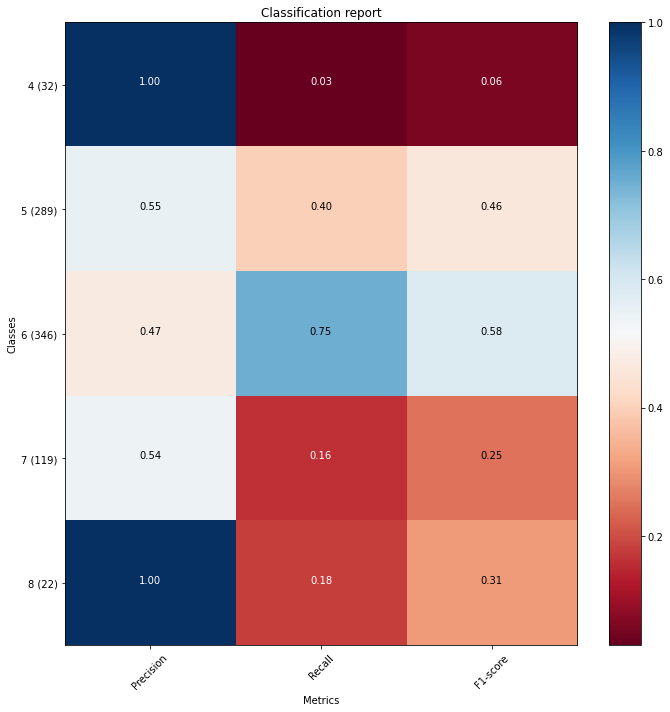

In [15]:
svc_c = study.best_params['C']
model = sklearn.svm.SVC(C=svc_c, gamma="auto")
model.fit(train_x, train_y)

y_pred = model.predict(valid_x)
clf =classification_report(valid_y, y_pred)
plot_classification_report(clf)
print(clf)

In [16]:
def objective(trial):

    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    classifier_obj = sklearn.ensemble.RandomForestClassifier(
        max_depth=rf_max_depth, n_estimators=10)

    score = sklearn.model_selection.cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-10 06:48:58,792] A new study created in memory with name: no-name-005577c0-730e-48a3-881e-6bab9c983ab0
[I 2021-12-10 06:48:58,989] Trial 0 finished with value: 0.5629368234221191 and parameters: {'max_depth': 11}. Best is trial 0 with value: 0.5629368234221191.
[I 2021-12-10 06:48:59,160] Trial 1 finished with value: 0.5732631348636722 and parameters: {'max_depth': 18}. Best is trial 1 with value: 0.5732631348636722.
[I 2021-12-10 06:48:59,288] Trial 2 finished with value: 0.5641764919986422 and parameters: {'max_depth': 6}. Best is trial 1 with value: 0.5732631348636722.
[I 2021-12-10 06:48:59,399] Trial 3 finished with value: 0.5377615828497349 and parameters: {'max_depth': 4}. Best is trial 1 with value: 0.5732631348636722.
[I 2021-12-10 06:48:59,492] Trial 4 finished with value: 0.524561285124795 and parameters: {'max_depth': 2}. Best is trial 1 with value: 0.5732631348636722.
[I 2021-12-10 06:48:59,614] Trial 5 finished with value: 0.5699479799281043 and parameters: {'m

Number of finished trials: 100
Best trial:
  Value: 0.5893527549781
  Params: 
    max_depth: 28


              precision    recall  f1-score   support

           4       1.00      0.06      0.12        32
           5       0.69      0.61      0.64       289
           6       0.58      0.78      0.66       346
           7       0.69      0.45      0.55       119
           8       0.89      0.36      0.52        22

    accuracy                           0.63       808
   macro avg       0.77      0.45      0.50       808
weighted avg       0.66      0.63      0.61       808



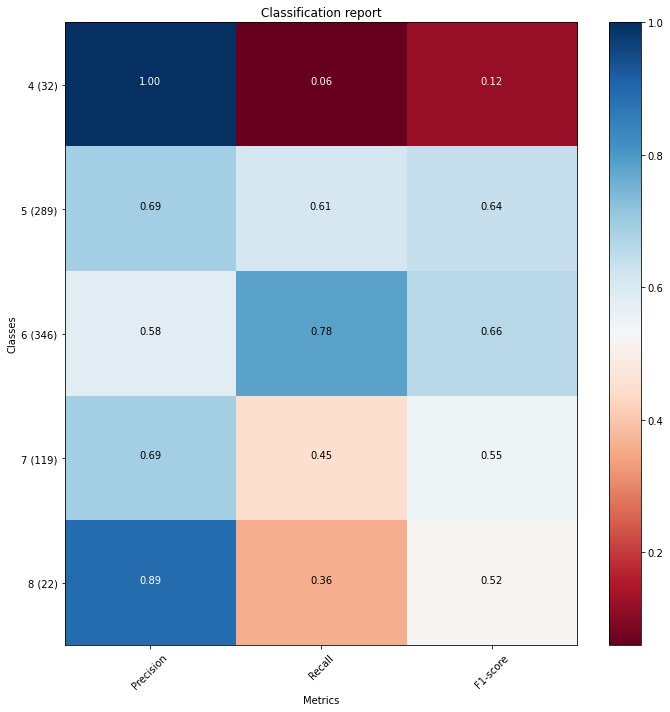

In [17]:
rf_best = study.best_params
model = sklearn.ensemble.RandomForestClassifier(**rf_best)
model.fit(train_x, train_y)

y_pred = model.predict(valid_x)
clf =classification_report(valid_y, y_pred)
plot_classification_report(clf)
print(clf)

In [18]:
import xgboost as xgb

train_y_label = train_y-4
valid_y_label = valid_y-4
train_x_tr, valid_x_es, train_y_tr, valid_y_es = train_test_split(train_x, train_y_label, test_size=0.2)

dtrain = xgb.DMatrix(train_x_tr, label=train_y_tr)
dtest = xgb.DMatrix(valid_x, label=valid_y_label)

def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "num_class": 5,
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "early_stopping_rounds":200,
        "evals":([valid_x_es,valid_y_es])
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y_label, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-10 06:49:14,340] A new study created in memory with name: no-name-49830bca-37ff-4f13-a9ea-87cc0c48b873
[I 2021-12-10 06:49:14,477] Trial 0 finished with value: 0.45792079207920794 and parameters: {'booster': 'gblinear', 'lambda': 0.012512309197175055, 'alpha': 0.0002556945691987358, 'subsample': 0.8275360229008348, 'colsample_bytree': 0.8789419971495744}. Best is trial 0 with value: 0.45792079207920794.
[I 2021-12-10 06:49:14,554] Trial 1 finished with value: 0.5457920792079208 and parameters: {'booster': 'gbtree', 'lambda': 0.009188150877843203, 'alpha': 0.0002506627220436429, 'subsample': 0.43064862686893446, 'colsample_bytree': 0.4279237522224881, 'max_depth': 3, 'min_child_weight': 9, 'eta': 2.994389882278651e-06, 'gamma': 6.239328877151942e-07, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.5457920792079208.
[I 2021-12-10 06:49:14,606] Trial 2 finished with value: 0.4282178217821782 and parameters: {'booster': 'gblinear', 'lambda': 0.02654054017436143, 'alph

Number of finished trials: 100
Best trial:
  Value: 0.5928217821782178
  Params: 
    booster: dart
    lambda: 0.9502663093462699
    alpha: 0.01344579857629845
    subsample: 0.9149626275413894
    colsample_bytree: 0.7638031137874213
    max_depth: 9
    min_child_weight: 6
    eta: 0.14830834464508338
    gamma: 0.7634833660756514
    grow_policy: lossguide
    sample_type: weighted
    normalize_type: tree
    rate_drop: 0.0003866694441511493
    skip_drop: 0.13875870664225398


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.66      0.62      0.64       289
           2       0.56      0.72      0.63       346
           3       0.56      0.41      0.47       119
           4       0.50      0.05      0.08        22

    accuracy                           0.59       808
   macro avg       0.45      0.36      0.36       808
weighted avg       0.57      0.59      0.57       808



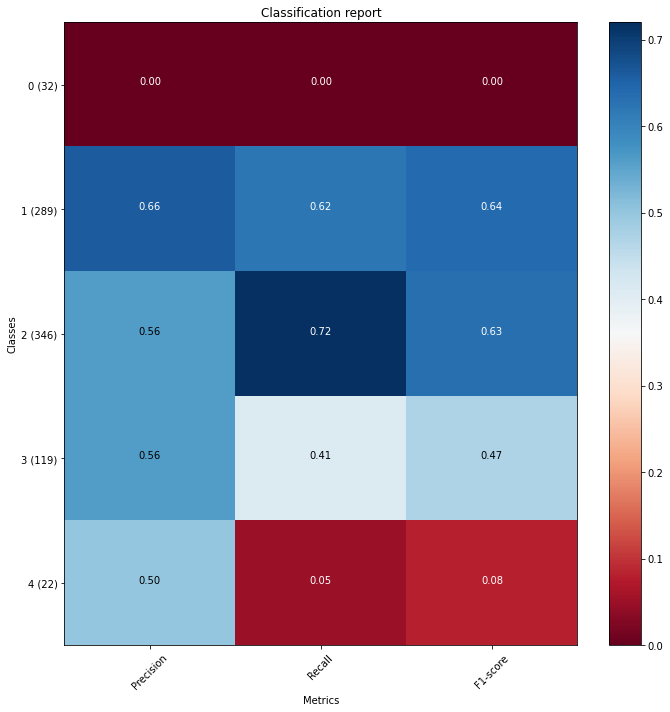

In [19]:
xgb_best = study.best_params
model = xgb.XGBClassifier(**xgb_best)
model.fit(train_x_tr,train_y_tr,eval_set=[(valid_x_es,valid_y_es)],early_stopping_rounds=200,verbose=False)
y_pred = model.predict(valid_x)
clf =classification_report(valid_y_label, y_pred)
plot_classification_report(clf)
print(clf)

In [20]:
import lightgbm as lgb

train_y_label = train_y-4
valid_y_label = valid_y-4
dtrain = lgb.Dataset(train_x, label=train_y_label)

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'num_class':5,
        "feature_pre_filter": False
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = []
    for i in range(0,len(preds)):
        pred_labels.append(np.argmax(preds[i]))
    accuracy = cal_acc(valid_y_label, pred_labels)
    return accuracy

def cal_acc(true, pred):
    return np.mean(true==pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-10 06:49:38,336] A new study created in memory with name: no-name-fb6d4b23-09a0-46b3-8e71-35ff335aaee4
[I 2021-12-10 06:49:38,866] Trial 0 finished with value: 0.5841584158415841 and parameters: {'lambda_l1': 3.4730932910294865e-07, 'lambda_l2': 0.0019650550926276406, 'num_leaves': 243, 'feature_fraction': 0.5511005411397201, 'bagging_fraction': 0.6487009274136456, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 0 with value: 0.5841584158415841.
[I 2021-12-10 06:49:39,139] Trial 1 finished with value: 0.5767326732673267 and parameters: {'lambda_l1': 2.994112551753236e-05, 'lambda_l2': 1.0480963335293329e-05, 'num_leaves': 219, 'feature_fraction': 0.7427921240109274, 'bagging_fraction': 0.47655846122331424, 'bagging_freq': 3, 'min_child_samples': 80}. Best is trial 0 with value: 0.5841584158415841.
[I 2021-12-10 06:49:40,062] Trial 2 finished with value: 0.6262376237623762 and parameters: {'lambda_l1': 2.7056191876079463e-06, 'lambda_l2': 0.0002819667781901348, 'nu

Number of finished trials: 100
Best trial:
  Value: 0.6423267326732673
  Params: 
    lambda_l1: 1.8220405915798492e-07
    lambda_l2: 4.1471293733421515e-06
    num_leaves: 151
    feature_fraction: 0.5368091866978398
    bagging_fraction: 0.6010587358707938
    bagging_freq: 7
    min_child_samples: 14


              precision    recall  f1-score   support

           0       0.50      0.06      0.11        32
           1       0.70      0.64      0.67       289
           2       0.59      0.77      0.67       346
           3       0.72      0.47      0.57       119
           4       0.89      0.36      0.52        22

    accuracy                           0.64       808
   macro avg       0.68      0.46      0.51       808
weighted avg       0.65      0.64      0.63       808



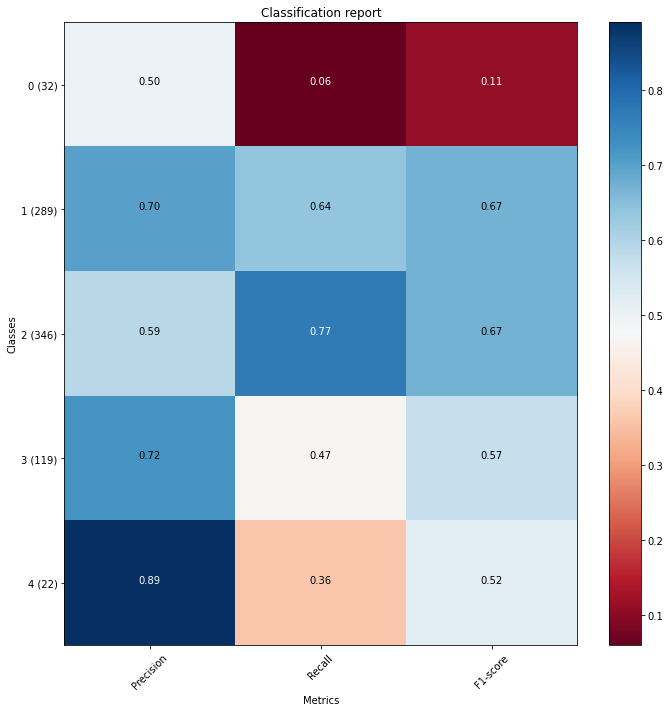

In [21]:
lgb_best = study.best_params
model = lgb.LGBMClassifier(**lgb_best)
model.fit(train_x, train_y_label)
y_pred = model.predict(valid_x)
clf =classification_report(valid_y_label, y_pred)
plot_classification_report(clf)
print(clf)

In [22]:
cat_best ={'max_depth':8}

In [25]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 93 kB/s 


In [26]:
import catboost as cat
from numpy import mean
from numpy import std
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

In [27]:
# compare ensemble to each baseline classifier
 
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('svc', sklearn.svm.SVC(C=svc_c, gamma="auto")))
    level0.append(('rf', sklearn.ensemble.RandomForestClassifier(**rf_best)))
    level0.append(('lgb', lgb.LGBMClassifier(**lgb_best)))
    level0.append(('xgb', xgb.XGBClassifier(**xgb_best)))
    level0.append(('cat', cat.CatBoostClassifier(**cat_best)))
    # define meta learner model
    level1 = LogisticRegression(max_iter=4000)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['svc'] = sklearn.svm.SVC(C=svc_c, gamma="auto")
    models['rf'] = sklearn.ensemble.RandomForestClassifier(**rf_best)
    models['lgb'] = lgb.LGBMClassifier(**lgb_best)
    models['xgb'] = xgb.XGBClassifier(**xgb_best)
    models['cat'] = cat.CatBoostClassifier(**cat_best)
    models['stacking'] = get_stacking()
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
# X = train.iloc[:,:-1]
# y = train.iloc[:,-1]
# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model, X, y)
# 	results.append(scores)
# 	names.append(name)
# 	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

In [ ]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

In [32]:
X_samp, y_samp = SMOTE(random_state=103).fit_resample(X, y)

In [37]:
level0 = list()
level0.append(('svc', sklearn.svm.SVC(C=svc_c, gamma="auto")))
level0.append(('rf', sklearn.ensemble.RandomForestClassifier(**rf_best)))
level0.append(('lgb', lgb.LGBMClassifier(**lgb_best)))
level0.append(('xgb', xgb.XGBClassifier(**xgb_best)))
level0.append(('cat', cat.CatBoostClassifier(**cat_best)))
# define meta learner model
level1 = LogisticRegression(max_iter=4000)
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
model.fit(X, y)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4:	learn: 1.3476729	total: 124ms	remaining: 24.7s
5:	learn: 1.3129841	total: 149ms	remaining: 24.6s
6:	learn: 1.2795806	total: 181ms	remaining: 25.6s
7:	learn: 1.2520282	total: 210ms	remaining: 26s
8:	learn: 1.2278335	total: 234ms	remaining: 25.8s
9:	learn: 1.2042078	total: 258ms	remaining: 25.6s
10:	learn: 1.1825719	total: 286ms	remaining: 25.7s
11:	learn: 1.1634910	total: 311ms	remaining: 25.6s
12:	learn: 1.1458465	total: 335ms	remaining: 25.4s
13:	learn: 1.1283155	total: 359ms	remaining: 25.3s
14:	learn: 1.1135569	total: 383ms	remaining: 25.2s
15:	learn: 1.0980173	total: 409ms	remaining: 25.2s
16:	learn: 1.0844908	total: 440ms	remaining: 25.4s
17:	learn: 1.0731357	total: 464ms	remaining: 25.3s
18:	learn: 1.0620837	total: 488ms	remaining: 25.2s
19:	learn: 1.0511998	total: 513ms	remaining: 25.1s
20:	learn: 1.0405161	total: 537ms	remaining: 25s
21:	learn: 1.0311586	total: 561ms	remaining: 24.9s
22:	learn: 1.0227694	total: 585ms	remaining: 24.9s
23:	l

StackingClassifier(cv=5,
                   estimators=[('svc', SVC(C=0.9475932857365966, gamma='auto')),
                               ('rf', RandomForestClassifier(max_depth=28)),
                               ('lgb',
                                LGBMClassifier(bagging_fraction=0.6010587358707938,
                                               bagging_freq=7,
                                               feature_fraction=0.5368091866978398,
                                               lambda_l1=1.8220405915798492e-07,
                                               lambda_l2=4.1471293733421515e-06,
                                               min_child_samples=14,
                                               num_leaves=151)),
                               ('xgb',
                                XGB...
                                              gamma=0.7634833660756514,
                                              grow_policy='lossguide',
                              

In [38]:
y_test = model.predict(test)
sub = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/sample_submission.csv')
sub['quality'] = y_test
sub.to_csv('/content/gdrive/My Drive/Colab Notebooks/stacking3.csv', index=False)